### Importing Library

In [86]:
import pandas as pd
import numpy as np

from pathlib import Path, os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import copy

import datetime

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from statsmodels.tsa.arima_model import ARIMA

### Importing Dataset

In [2]:
path = Path(os.getcwd()).parent
age_details = pd.read_csv(path / 'covid19-in-india/AgeGroupDetails.csv')
india_covid_19 = pd.read_csv(path / 'covid19-in-india/covid_19_india.csv')
hospital_beds = pd.read_csv(path / 'covid19-in-india/HospitalBedsIndia.csv')
individual_details = pd.read_csv(path / 'covid19-in-india/IndividualDetails.csv')
ICMR_labs = pd.read_csv(path / 'covid19-in-india/ICMRTestingLabs.csv')
state_testing = pd.read_csv(path / 'covid19-in-india/StatewiseTestingDetails.csv', na_values=' ')
population = pd.read_csv(path / 'covid19-in-india/population_india_census2011.csv')
india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])

world_population = pd.read_csv(path / 'population-by-country-2020/population_by_country_2020.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

In [3]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
print('world_confirmed',world_confirmed)
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
print('world_recovered', world_recovered)
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
print('world_deaths',world_deaths)
world_active = world_confirmed -(world_recovered + world_deaths)
print('world_active',world_active)

world_confirmed 9/4/20    26609482
dtype: int64
world_recovered 9/4/20    17717266
dtype: int64
world_deaths 9/4/20    874369
dtype: int64
world_active 9/4/20    8017847
dtype: int64


In [4]:
labels = ['Active', 'Recovered', 'Deceased']
sizes = [world_active, world_recovered, world_deaths]
color = ['#66b3ff','green','orange']
explode = [.05,.05,.05]

<ipython-input-5-f82443a37c8e>:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=9,explode=explode,colors=color)


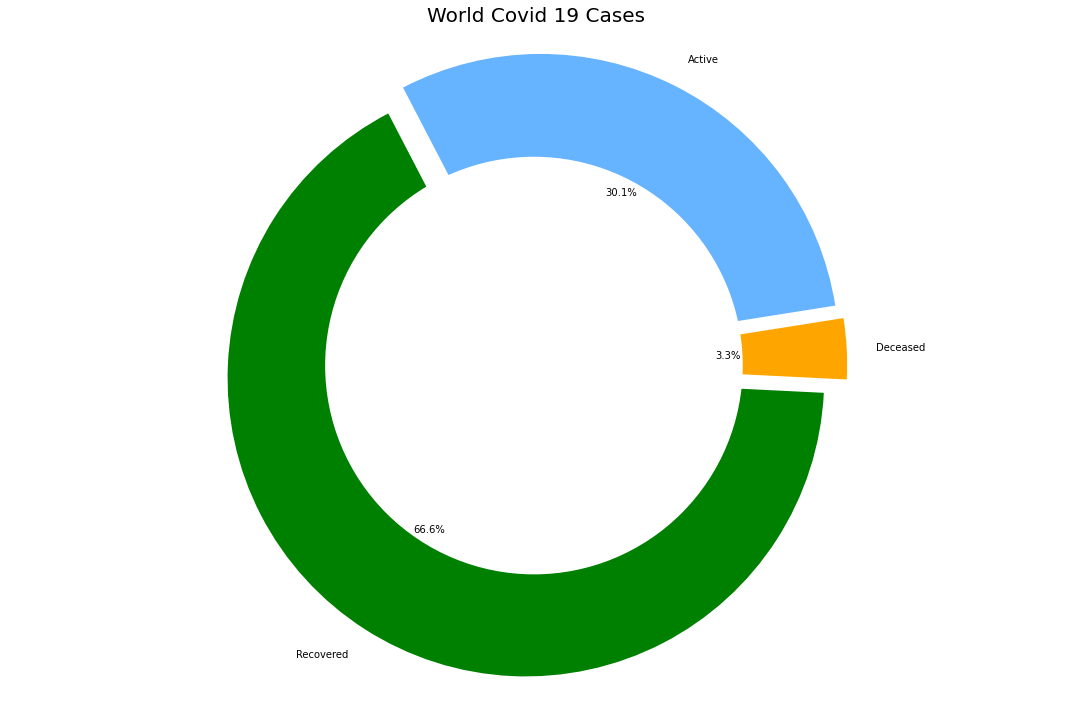

In [5]:
plt.figure(figsize=(15,10))
plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=9,explode=explode,colors=color)
centre_circle = plt.Circle((0,0),0.7,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World Covid 19 Cases', fontsize=20)
plt.axis('equal')
plt.tight_layout()

In [6]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates_india = pd.to_datetime(confirmed_df.columns[4:])[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = dict()
global_deaths = dict()
global_recovered = dict()
global_active = dict()
for country in hotspots:
    global_confirmed[country] = df1[df1['Country/Region']==country].loc[:,'1/30/20':].values.tolist()[0]
    global_deaths[country] = df2[df2['Country/Region']==country].loc[:,'1/30/20':].values.tolist()[0]
    global_recovered[country] = df3[df3['Country/Region']==country].loc[:,'1/30/20':].values.tolist()[0]
    global_active[country] = list(map(int.__sub__, global_confirmed[country],list(map(int.__add__,global_deaths[country],global_recovered[country]))))


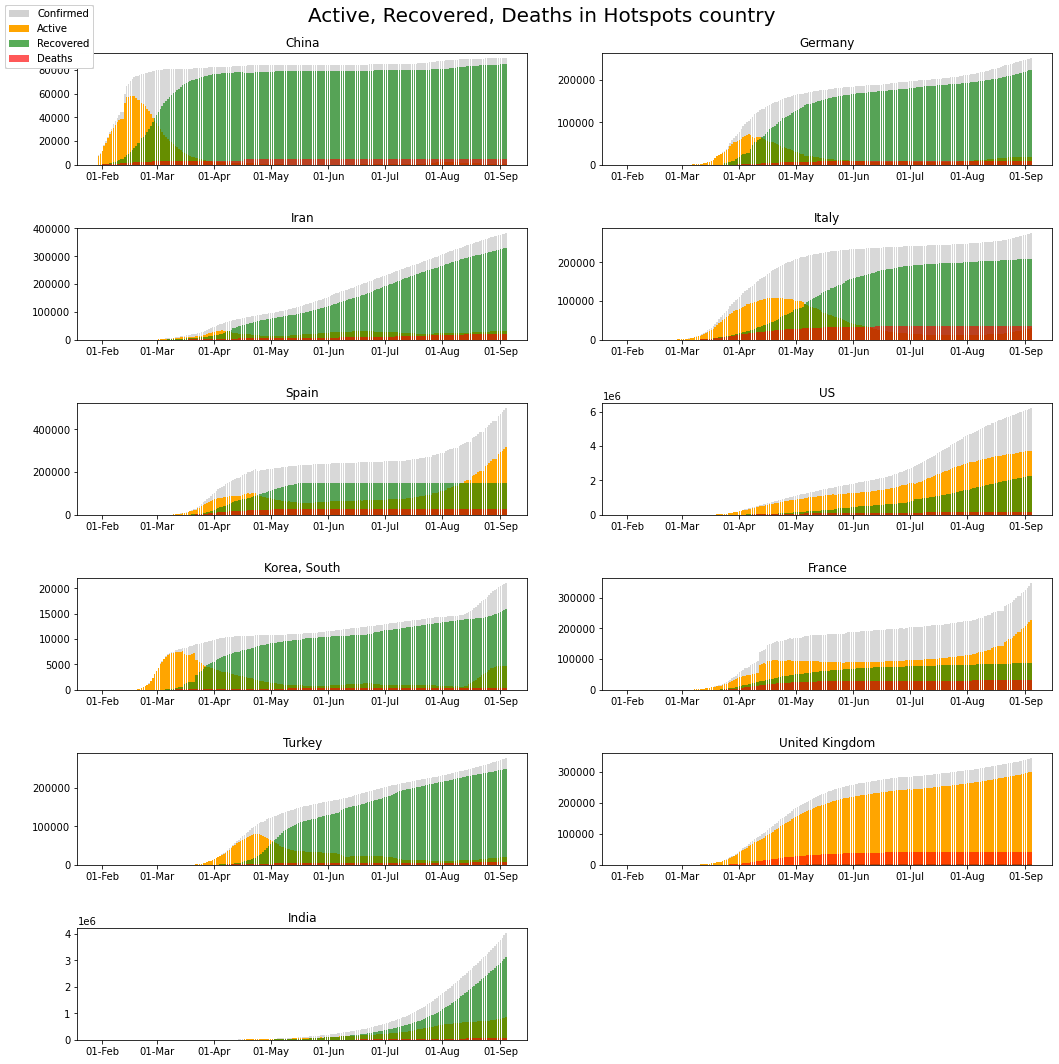

In [7]:
fig = plt.figure(figsize=(15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspots country', fontsize=20,y=1)
for i, country in enumerate(hotspots):
    ax = fig.add_subplot(6,2,i+1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_confirmed[country],color='grey',alpha=0.3,label='Confirmed')
    ax.bar(dates_india,global_active[country],color='orange',label='Active')
    ax.bar(dates_india,global_recovered[country],color='green',alpha=0.6,label='Recovered')
    ax.bar(dates_india,global_deaths[country],color='red',alpha=0.6,label='Deaths')
    plt.title(country)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')

plt.tight_layout(pad=3)

In [8]:
world_population_copy = copy.deepcopy(world_population)

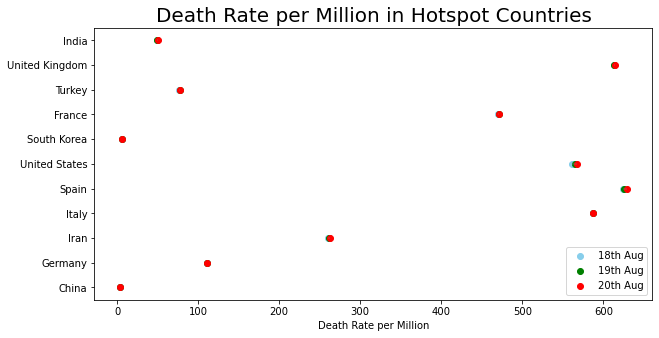

In [9]:
hotspots = ['China','Germany','Iran','Italy','Spain','United States','South Korea','France','Turkey','United Kingdom','India']
country_death_rate = pd.DataFrame(columns=['country','day1','day2','day3'])
world_population['Population (2020)'] = world_population_copy['Population (2020)']/1000000

d1 = list()
d2 = list()
d3 = list()
for country in hotspots:
    p = float(world_population[world_population['Country (or dependency)'] == country ]['Population (2020)'])
    if country == 'United States':
        k = global_deaths['US'][-3:]
    elif country == 'South Korea':
        k = global_deaths['Korea, South'][-3:]
    else:
        k = global_deaths[country][-3:]
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))
country_death_rate['country'] = hotspots
country_death_rate['day1'] = d1
country_death_rate['day2'] = d2
country_death_rate['day3'] = d3

plt.figure(figsize= (10,5))
plt.hlines(y=country_death_rate['country'], xmin=country_death_rate['day1'], xmax=country_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(country_death_rate['day1'], country_death_rate['country'], color='skyblue', label='18th Aug');
plt.scatter(country_death_rate['day2'], country_death_rate['country'], color='green', label='19th Aug');
plt.scatter(country_death_rate['day3'], country_death_rate['country'], color='red', label='20th Aug');
plt.legend();
plt.title("Death Rate per Million in Hotspot Countries",fontsize=20);
plt.xlabel('Death Rate per Million');


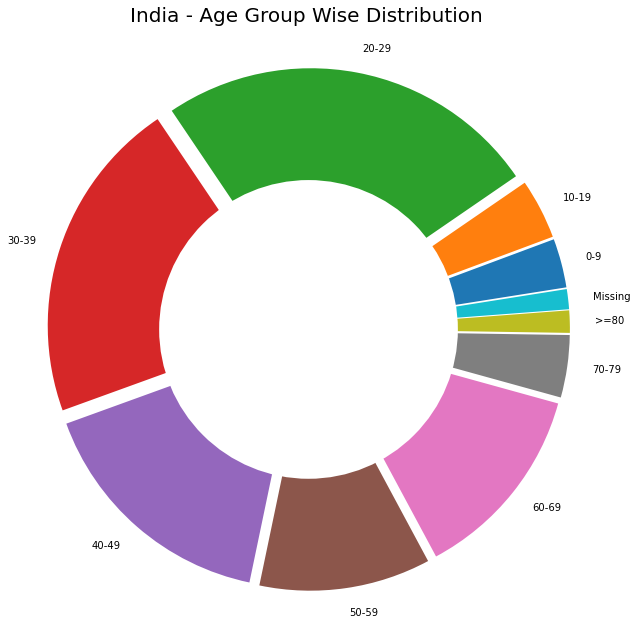

In [10]:
plt.figure(figsize=(9,9))
plt.pie(age_details['TotalCases'],labels=age_details['AgeGroup'],startangle=9,explode=[.05]*len(age_details))

fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0,0),.6,fc='white'))
plt.title('India - Age Group Wise Distribution',fontsize=20)
plt.axis('equal')
plt.tight_layout()

In [11]:
sizes = [individual_details['gender'].isnull().sum(),individual_details['gender'].value_counts()['M'],individual_details['gender'].value_counts()['F']]

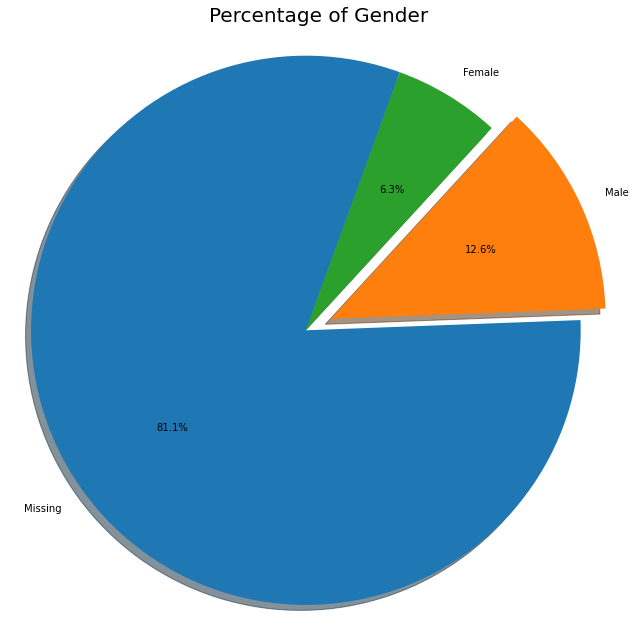

In [12]:
plt.figure(figsize=(9,9))
plt.title('Percentage of Gender',fontsize=20)
plt.pie(sizes,explode=(0,.1,0),labels=['Missing','Male','Female'],autopct='%1.1f%%',shadow=True,startangle=70)
plt.axis('equal')
plt.tight_layout()

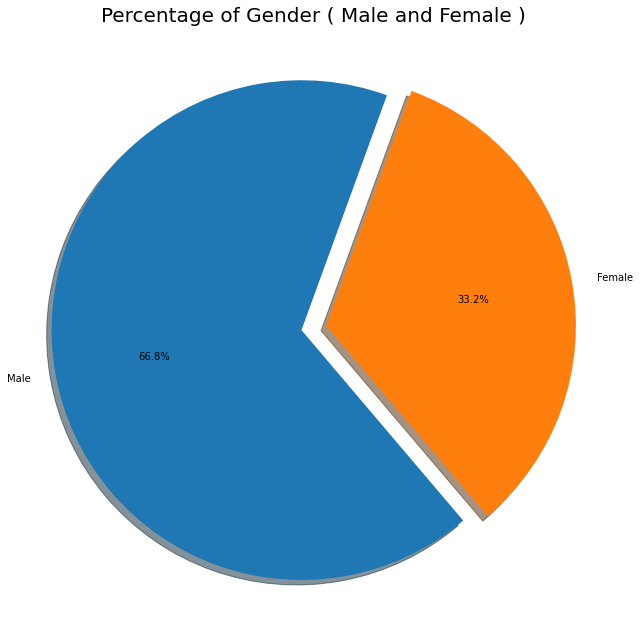

In [13]:
plt.figure(figsize=(9,9))
plt.title('Percentage of Gender ( Male and Female )',fontsize=20)
plt.pie(sizes[1:],explode=(.1,0),labels=['Male','Female'],autopct='%1.1f%%',shadow=True,startangle=70)
plt.axis('equal')
plt.tight_layout()

In [14]:
dates_india = pd.to_datetime(confirmed_df.columns[4:].tolist()).tolist()[8:]

In [15]:
cdf = confirmed_df.groupby('Country/Region').sum().reset_index()
ddf = deaths_df.groupby('Country/Region').sum().reset_index()
rdf = recovered_df.groupby('Country/Region').sum().reset_index()

In [16]:
india_confirmed = cdf[cdf['Country/Region']=='India'].loc[:,'1/30/20':].values.tolist()[0]
india_deaths = ddf[ddf['Country/Region']=='India'].loc[:,'1/30/20':].values.tolist()[0]
india_recovered = rdf[rdf['Country/Region']=='India'].loc[:,'1/30/20':].values.tolist()[0]

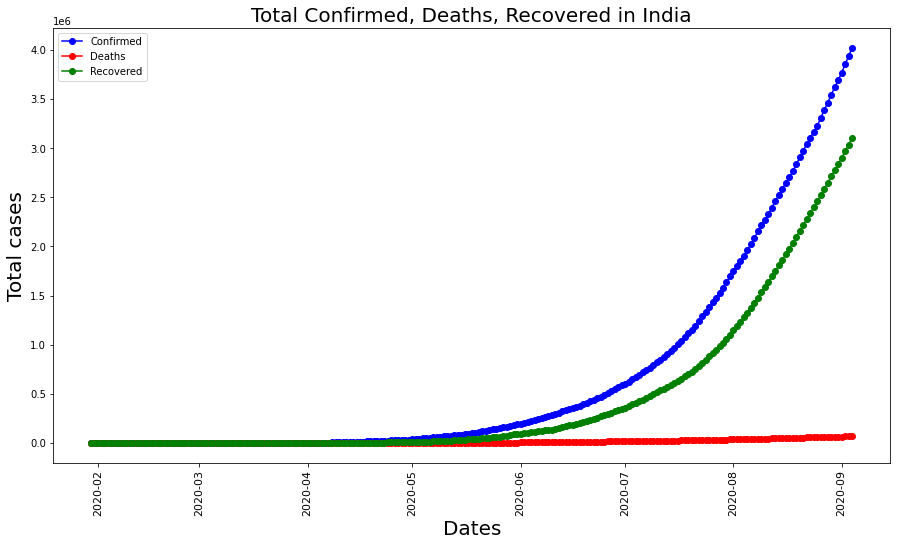

In [17]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90,fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Total cases',fontsize=20)
plt.title('Total Confirmed, Deaths, Recovered in India',fontsize=20)

plt.plot_date(y=india_confirmed,x=dates_india,label='Confirmed',linestyle='-',color='b')
plt.plot_date(y=india_deaths,x=dates_india,label='Deaths',linestyle='-',color='r')
plt.plot_date(y=india_recovered,x=dates_india,label='Recovered',linestyle='-',color='g')
plt.legend()

In [18]:
cdf.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20
0,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,...,38113,38129,38140,38143,38162,38165,38196,38243,38288,38304
1,Albania,41.15330,20.168300,0,0,0,0,0,0,0,...,8927,9083,9195,9279,9380,9513,9606,9728,9844,9967
2,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,...,42619,43016,43403,43781,44146,44494,44833,45158,45469,45773
3,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,...,1098,1098,1124,1124,1124,1176,1184,1199,1199,1215
4,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,...,2332,2415,2471,2551,2624,2654,2729,2777,2805,2876


In [19]:
cdf[cdf['Country/Region'].isin(['China','US','Italy','Spain','France','India'])]

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20
36,China,1085.292300,3688.937700,548,643,920,1406,2075,2877,5509,...,89784,89814,89836,89863,89895,89914,89933,89953,89986,90008
62,France,91.397395,60.040886,0,0,2,3,3,3,4,...,291374,297485,304947,304947,315813,318986,323968,331060,338220,347267
79,India,20.593684,78.962880,0,0,0,0,0,0,0,...,3310234,3387500,3463972,3542733,3621245,3691166,3769523,3853406,3936747,4023179
85,Italy,41.871940,12.567380,0,0,0,0,0,0,0,...,262540,263949,265409,266853,268218,269214,270189,271515,272912,274644
158,Spain,40.463667,-3.749220,0,0,0,0,0,0,0,...,419849,429507,439286,439286,439286,462858,470973,479554,488513,498989
174,US,40.000000,-100.000000,1,1,2,2,5,5,5,...,5821819,5867785,5913941,5961094,5996431,6030587,6073840,6113510,6150016,6200518


In [20]:
countries = ['China','France','India','Italy','Spain','US']
global_confirmed = cdf[cdf['Country/Region'].isin(countries)].loc[:,'1/30/20':]
global_confirmed['country'] = countries
global_deaths = ddf[ddf['Country/Region'].isin(countries)].loc[:,'1/30/20':]
global_deaths['country'] = countries
global_recovered = rdf[rdf['Country/Region'].isin(countries)].loc[:,'1/30/20':]
global_recovered['country'] = countries

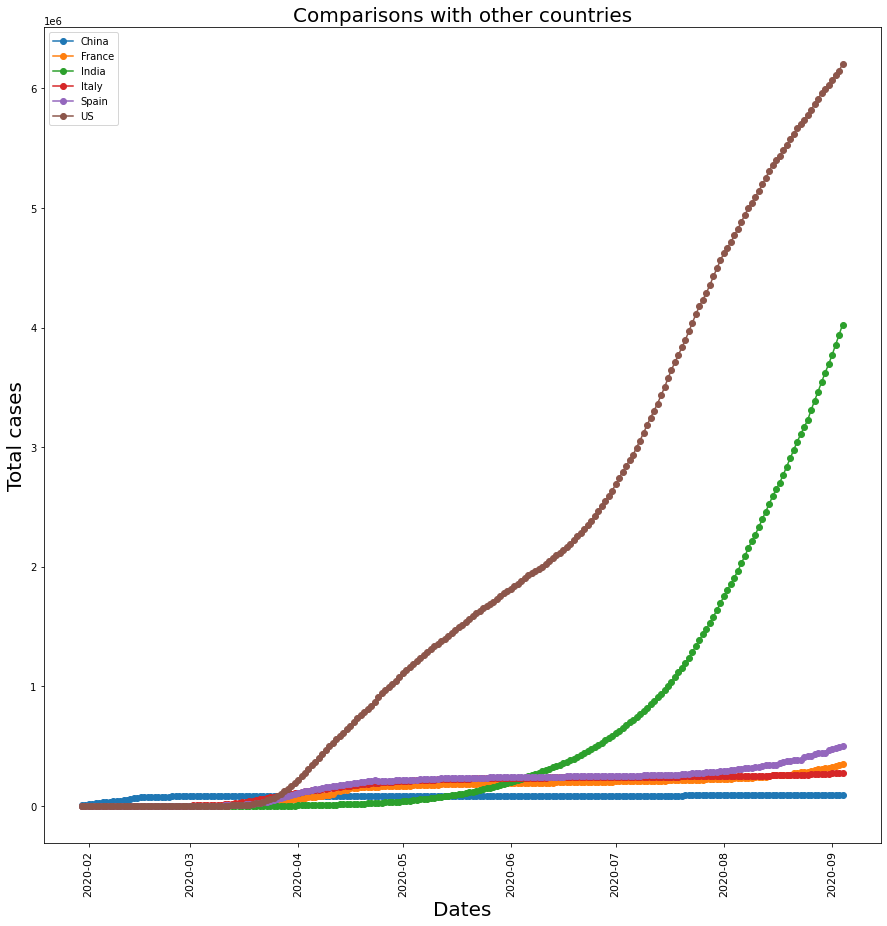

In [21]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90,fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Total cases',fontsize=20)
plt.title('Comparisons with other countries',fontsize=20)
for country in countries:
    plt.plot_date(y=global_confirmed[global_confirmed['country']==country].values.tolist()[0][:-1],x=dates_india,label=country,linestyle='-')
plt.legend()    

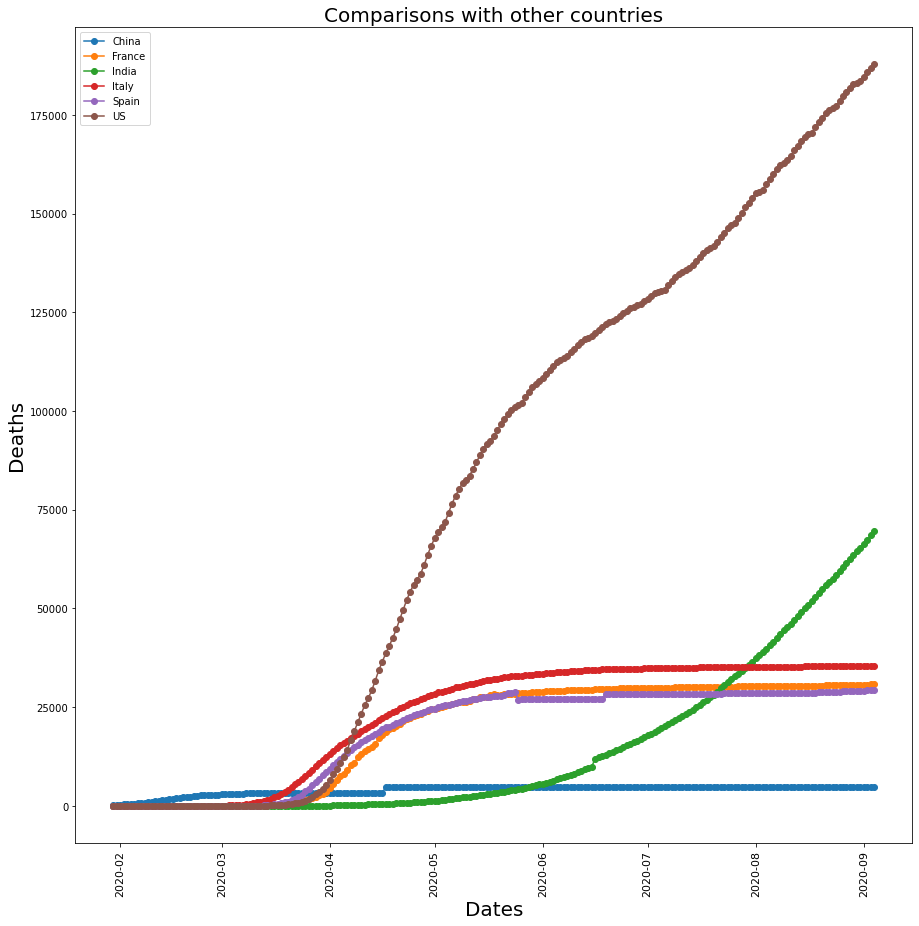

In [22]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90,fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Deaths',fontsize=20)
plt.title('Comparisons with other countries',fontsize=20)
for country in countries:
    plt.plot_date(y=global_deaths[global_deaths['country']==country].values.tolist()[0][:-1],x=dates_india,label=country,linestyle='-')
plt.legend()    

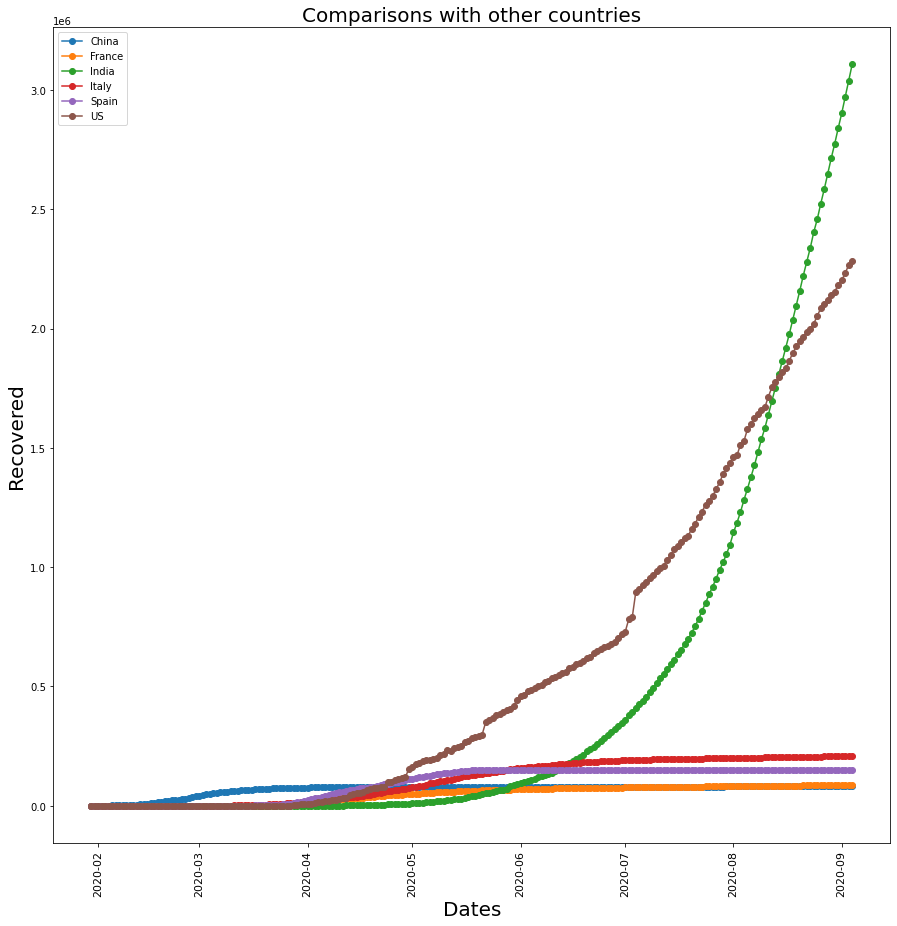

In [23]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90,fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Recovered',fontsize=20)
plt.title('Comparisons with other countries',fontsize=20)
for country in countries:
    plt.plot_date(y=global_recovered[global_recovered['country']==country].values.tolist()[0][:-1],x=dates_india,label=country,linestyle='-')
plt.legend()    

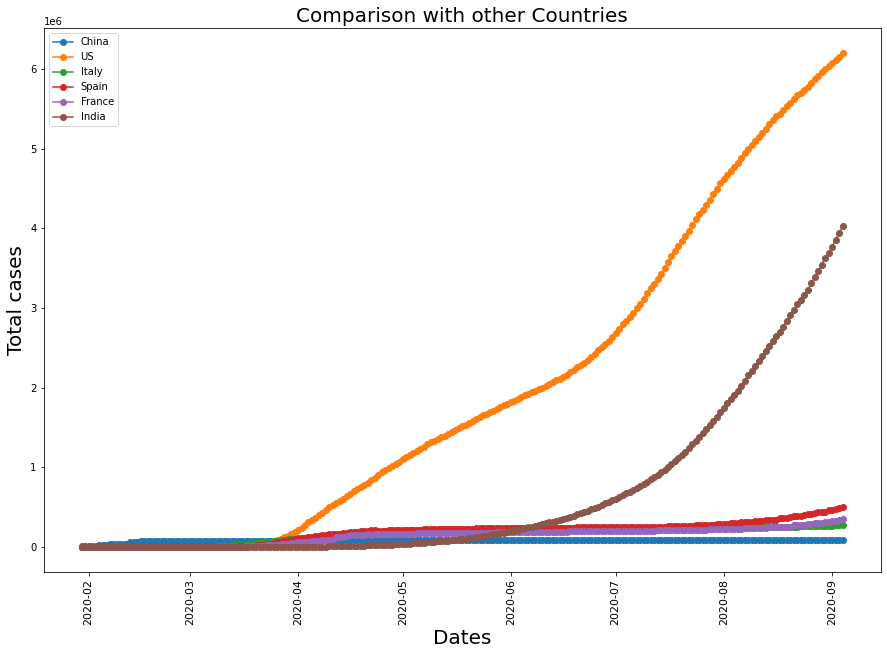

In [24]:
countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

In [25]:
state_cases = india_covid_19.groupby('State/UnionTerritory')[['Confirmed','Deaths','Cured']].max().reset_index()
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths'] + state_cases['Cured'])
state_cases['Death Rate (per 100)'] = np.round(100*state_cases['Deaths']/state_cases['Confirmed'],2)
state_cases['Cure Rate (per 100)'] = np.round(100*state_cases['Cured']/state_cases['Confirmed'],2)
state_cases.sort_values('Confirmed',ascending=False).fillna(0).style\
            .background_gradient(cmap='Blues',subset=['Confirmed'])\
            .background_gradient(cmap='Blues',subset=['Cured'])\
            .background_gradient(cmap='Blues',subset=['Deaths'])\
            .background_gradient(cmap='Blues',subset=['Active'])\
            .background_gradient(cmap='Blues',subset=['Death Rate (per 100)'])\
            .background_gradient(cmap='Blues',subset=['Cure Rate (per 100)'])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
22,Maharashtra,560126,19063,390958,150105,3.400000,69.800000
32,Tamil Nadu,320355,5397,261459,53499,1.680000,81.620000
1,Andhra Pradesh,264142,2378,170984,90780,0.900000,64.730000
18,Karnataka,203200,3613,121242,78345,1.780000,59.670000
11,Delhi,149460,4167,134318,10975,2.790000,89.870000
39,Uttar Pradesh,140775,2280,88786,49709,1.620000,63.070000
41,West Bengal,107323,2259,78617,26447,2.100000,73.250000
4,Bihar,94193,426,62284,31483,0.450000,66.120000
35,Telengana,88396,674,64284,23438,0.760000,72.720000
13,Gujarat,75408,2731,58467,14210,3.620000,77.530000


In [26]:
india_covid_19[india_covid_19['State/UnionTerritory']=='Telengana'].sort_values('Date', ascending= True)[india_covid_19['Date']>'2020-07-08']

<ipython-input-26-657e04c48bf3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  india_covid_19[india_covid_19['State/UnionTerritory']=='Telengana'].sort_values('Date', ascending= True)[india_covid_19['Date']>'2020-07-08']


,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
4596,4597,2020-07-28,8:00 AM,Telengana,-,-,42909,480,57142
4666,4667,2020-07-30,8:00 AM,Telengana,-,-,43751,492,58906
4701,4702,2020-07-31,8:00 AM,Telengana,-,-,44572,505,60717
4736,4737,2020-08-01,8:00 AM,Telengana,-,-,45388,519,62703
4771,4772,2020-08-02,8:00 AM,Telengana,-,-,46502,530,64786
4806,4807,2020-08-03,8:00 AM,Telengana,-,-,47590,540,66677
4841,4842,2020-08-04,8:00 AM,Telengana,-,-,49675,563,68946
4876,4877,2020-08-05,8:00 AM,Telengana,-,-,50814,576,70958
4911,4912,2020-08-06,8:00 AM,Telengana,-,-,52103,589,73050
4946,4947,2020-08-07,8:00 AM,Telengana,-,-,53239,601,75257


In [27]:
latest = india_covid_19[india_covid_19['Date']>'24-03-20']
state_cases = latest.groupby('State/UnionTerritory')[['Confirmed','Cured','Deaths']].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Cured'] + latest['Deaths'])
state_cases = state_cases.sort_values('Confirmed',ascending=False).fillna(0)
states = list(state_cases['State/UnionTerritory'].unique())
[states.remove(st) for st in ['Telangana***','Telengana***','Unassigned','Dadar Nagar Haveli','Daman & Diu','Cases being reassigned to states']]

<ipython-input-27-0574ef9ea5cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest['Active'] = latest['Confirmed'] - (latest['Cured'] + latest['Deaths'])


[None, None, None, None, None, None]

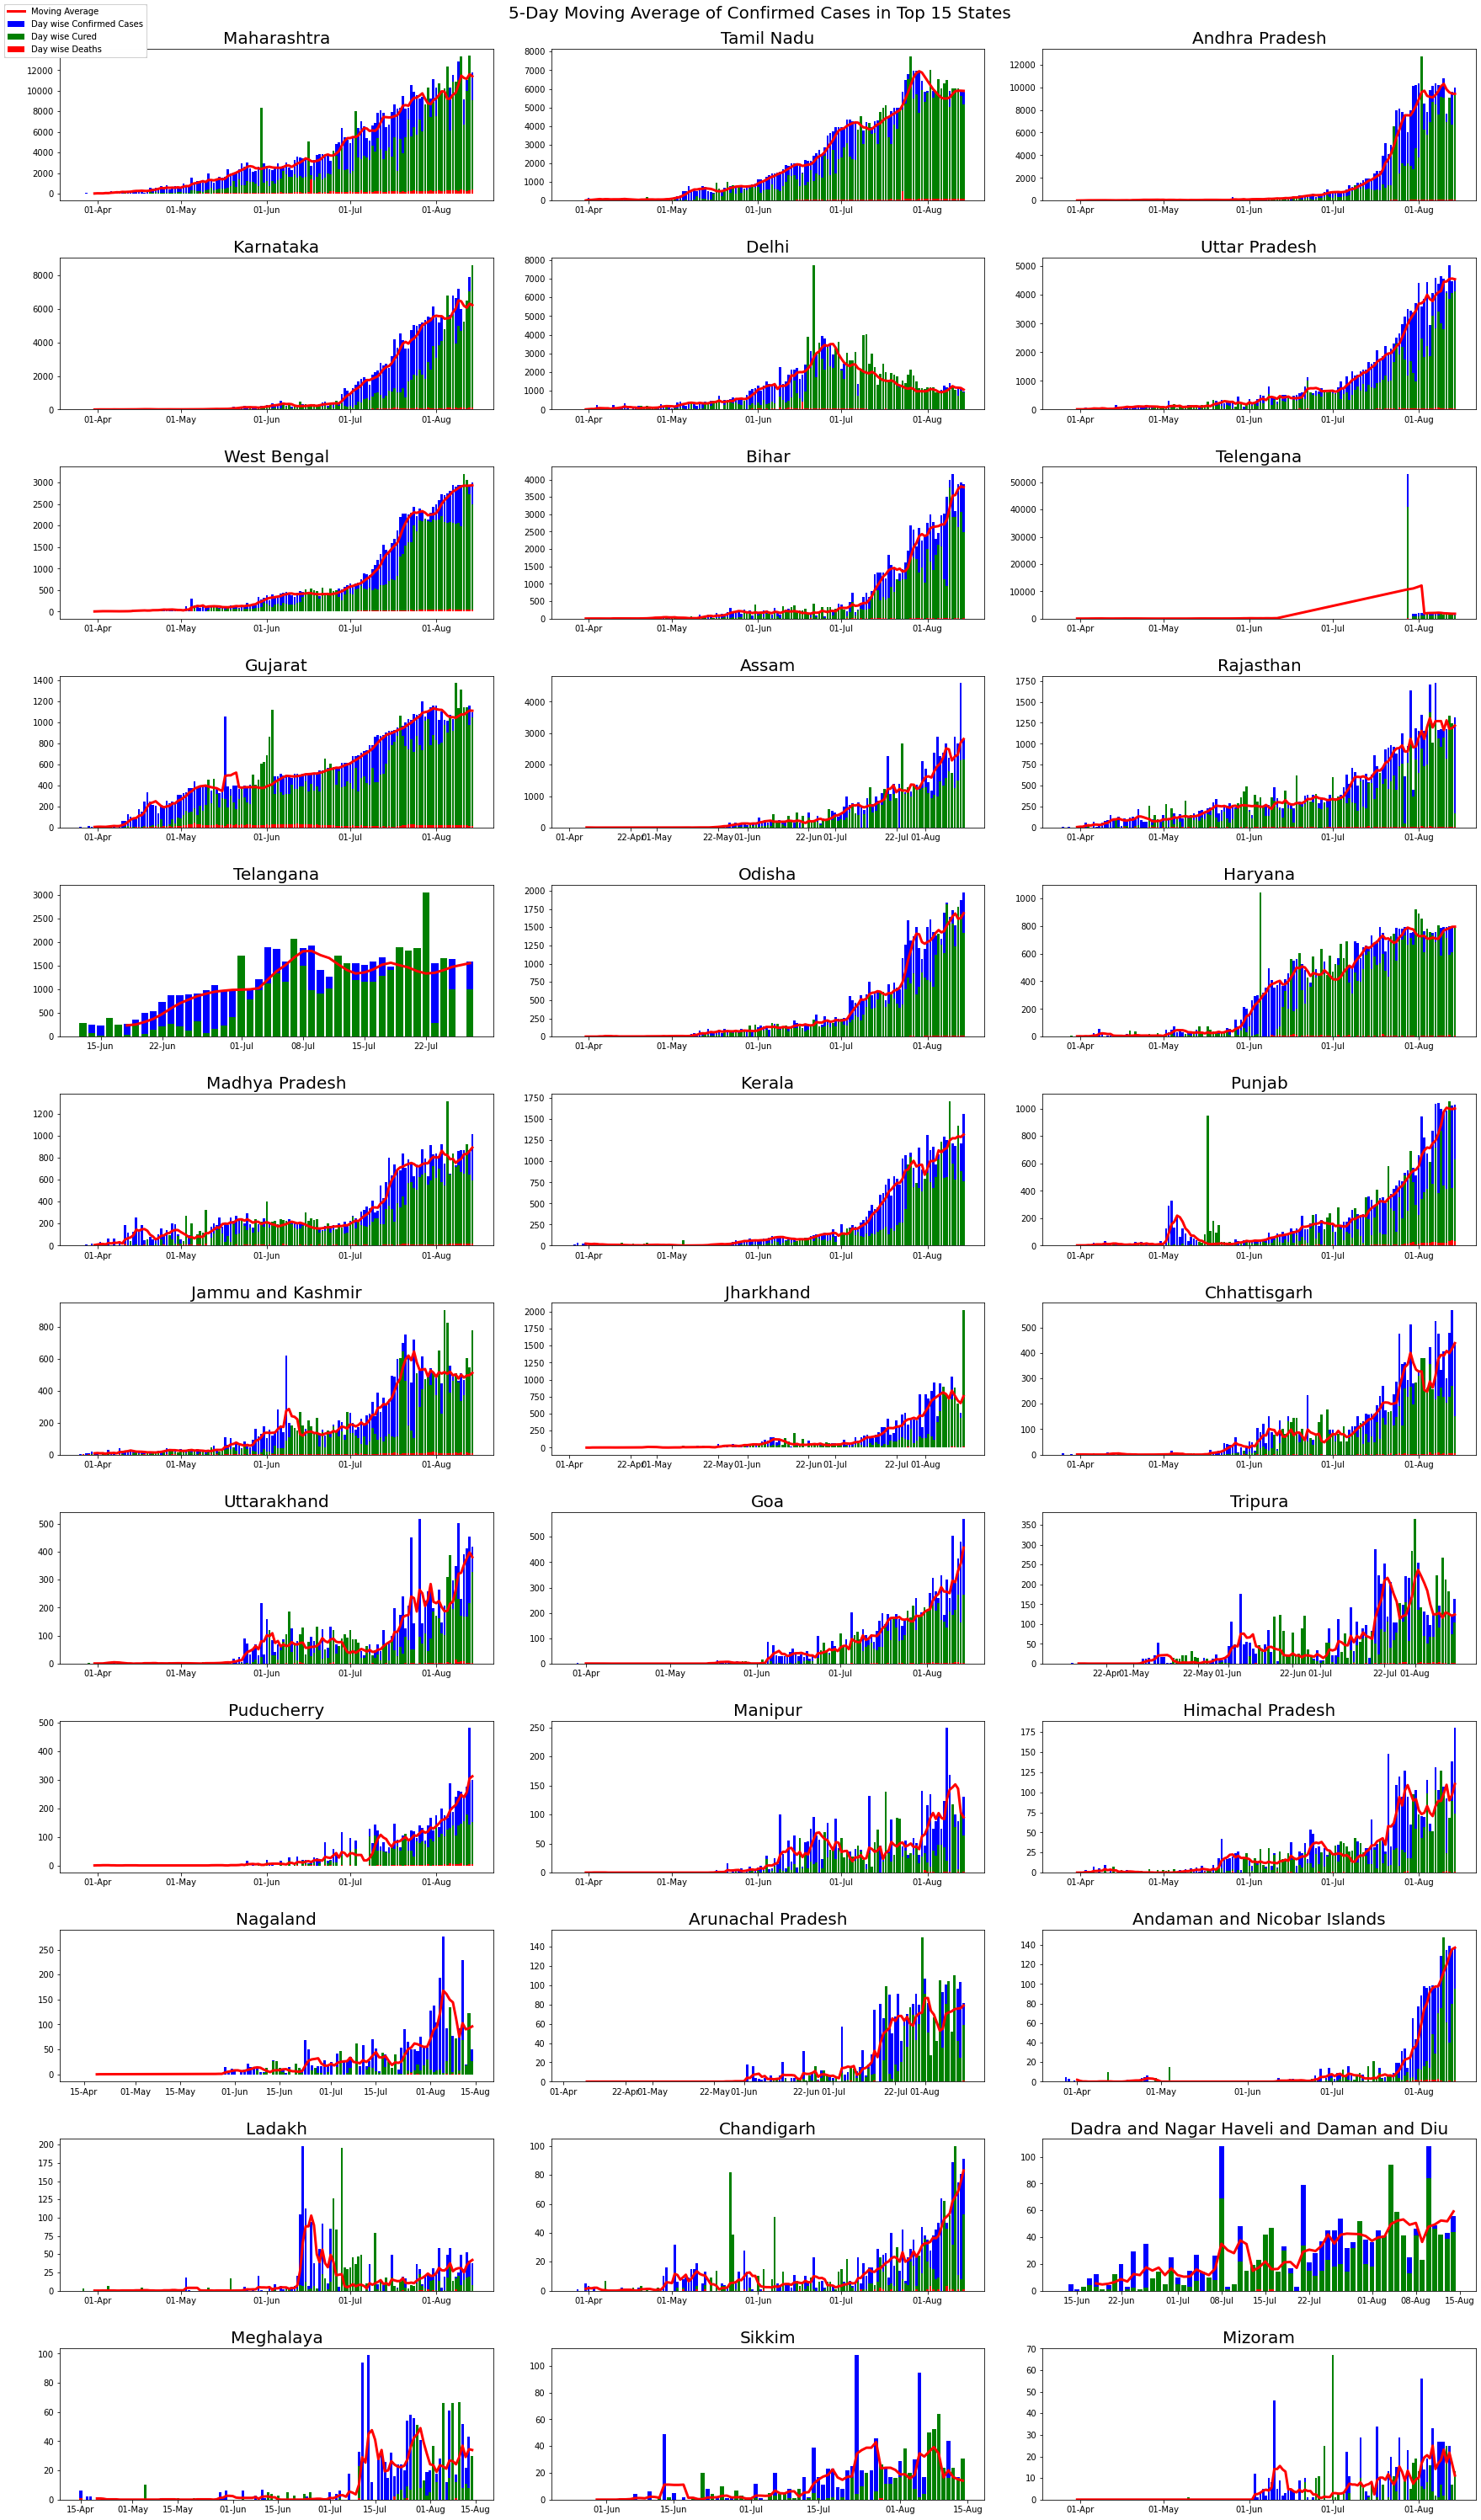

In [28]:
fig = plt.figure(figsize=(25,45))
plt.suptitle('5-Day Moving Average of Confirmed Cases in Top 15 States',fontsize=20,y=1)
for i, state in enumerate(states):
    df1 = latest[latest['State/UnionTerritory']==state][1:].sort_values('Date', ascending= True).reset_index().fillna(0)
    df2 = latest[latest['State/UnionTerritory']==state][:-1].sort_values('Date', ascending= True).reset_index().fillna(0)
    states_confirmed = list(df1['Confirmed']-df2['Confirmed'])
    states_deaths = list(df1['Deaths']-df2['Deaths'])
    states_recovered = list(df1['Cured']-df2['Cured'])
    states_dates = df1['Date'].tolist()
    swdf = pd.DataFrame({'states_confirmed':states_confirmed,
                        'states_deaths':states_deaths,
                        'states_recovered':states_recovered,
                        'states_dates':states_dates})
    ax = fig.add_subplot(len(states)//3+1,3,i+1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(states_dates,states_confirmed,label='Day wise Confirmed Cases',color='blue')
    ax.bar(states_dates,states_recovered,label='Day wise Cured',color='green')
    ax.bar(states_dates,states_deaths,label='Day wise Deaths',color='red')
    ax.plot(states_dates[5:],swdf.rolling(5).mean()['states_confirmed'][5:],color='red',label = 'Moving Average',linewidth =3)
    plt.title(state,fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc='upper left')
plt.tight_layout(pad=3)

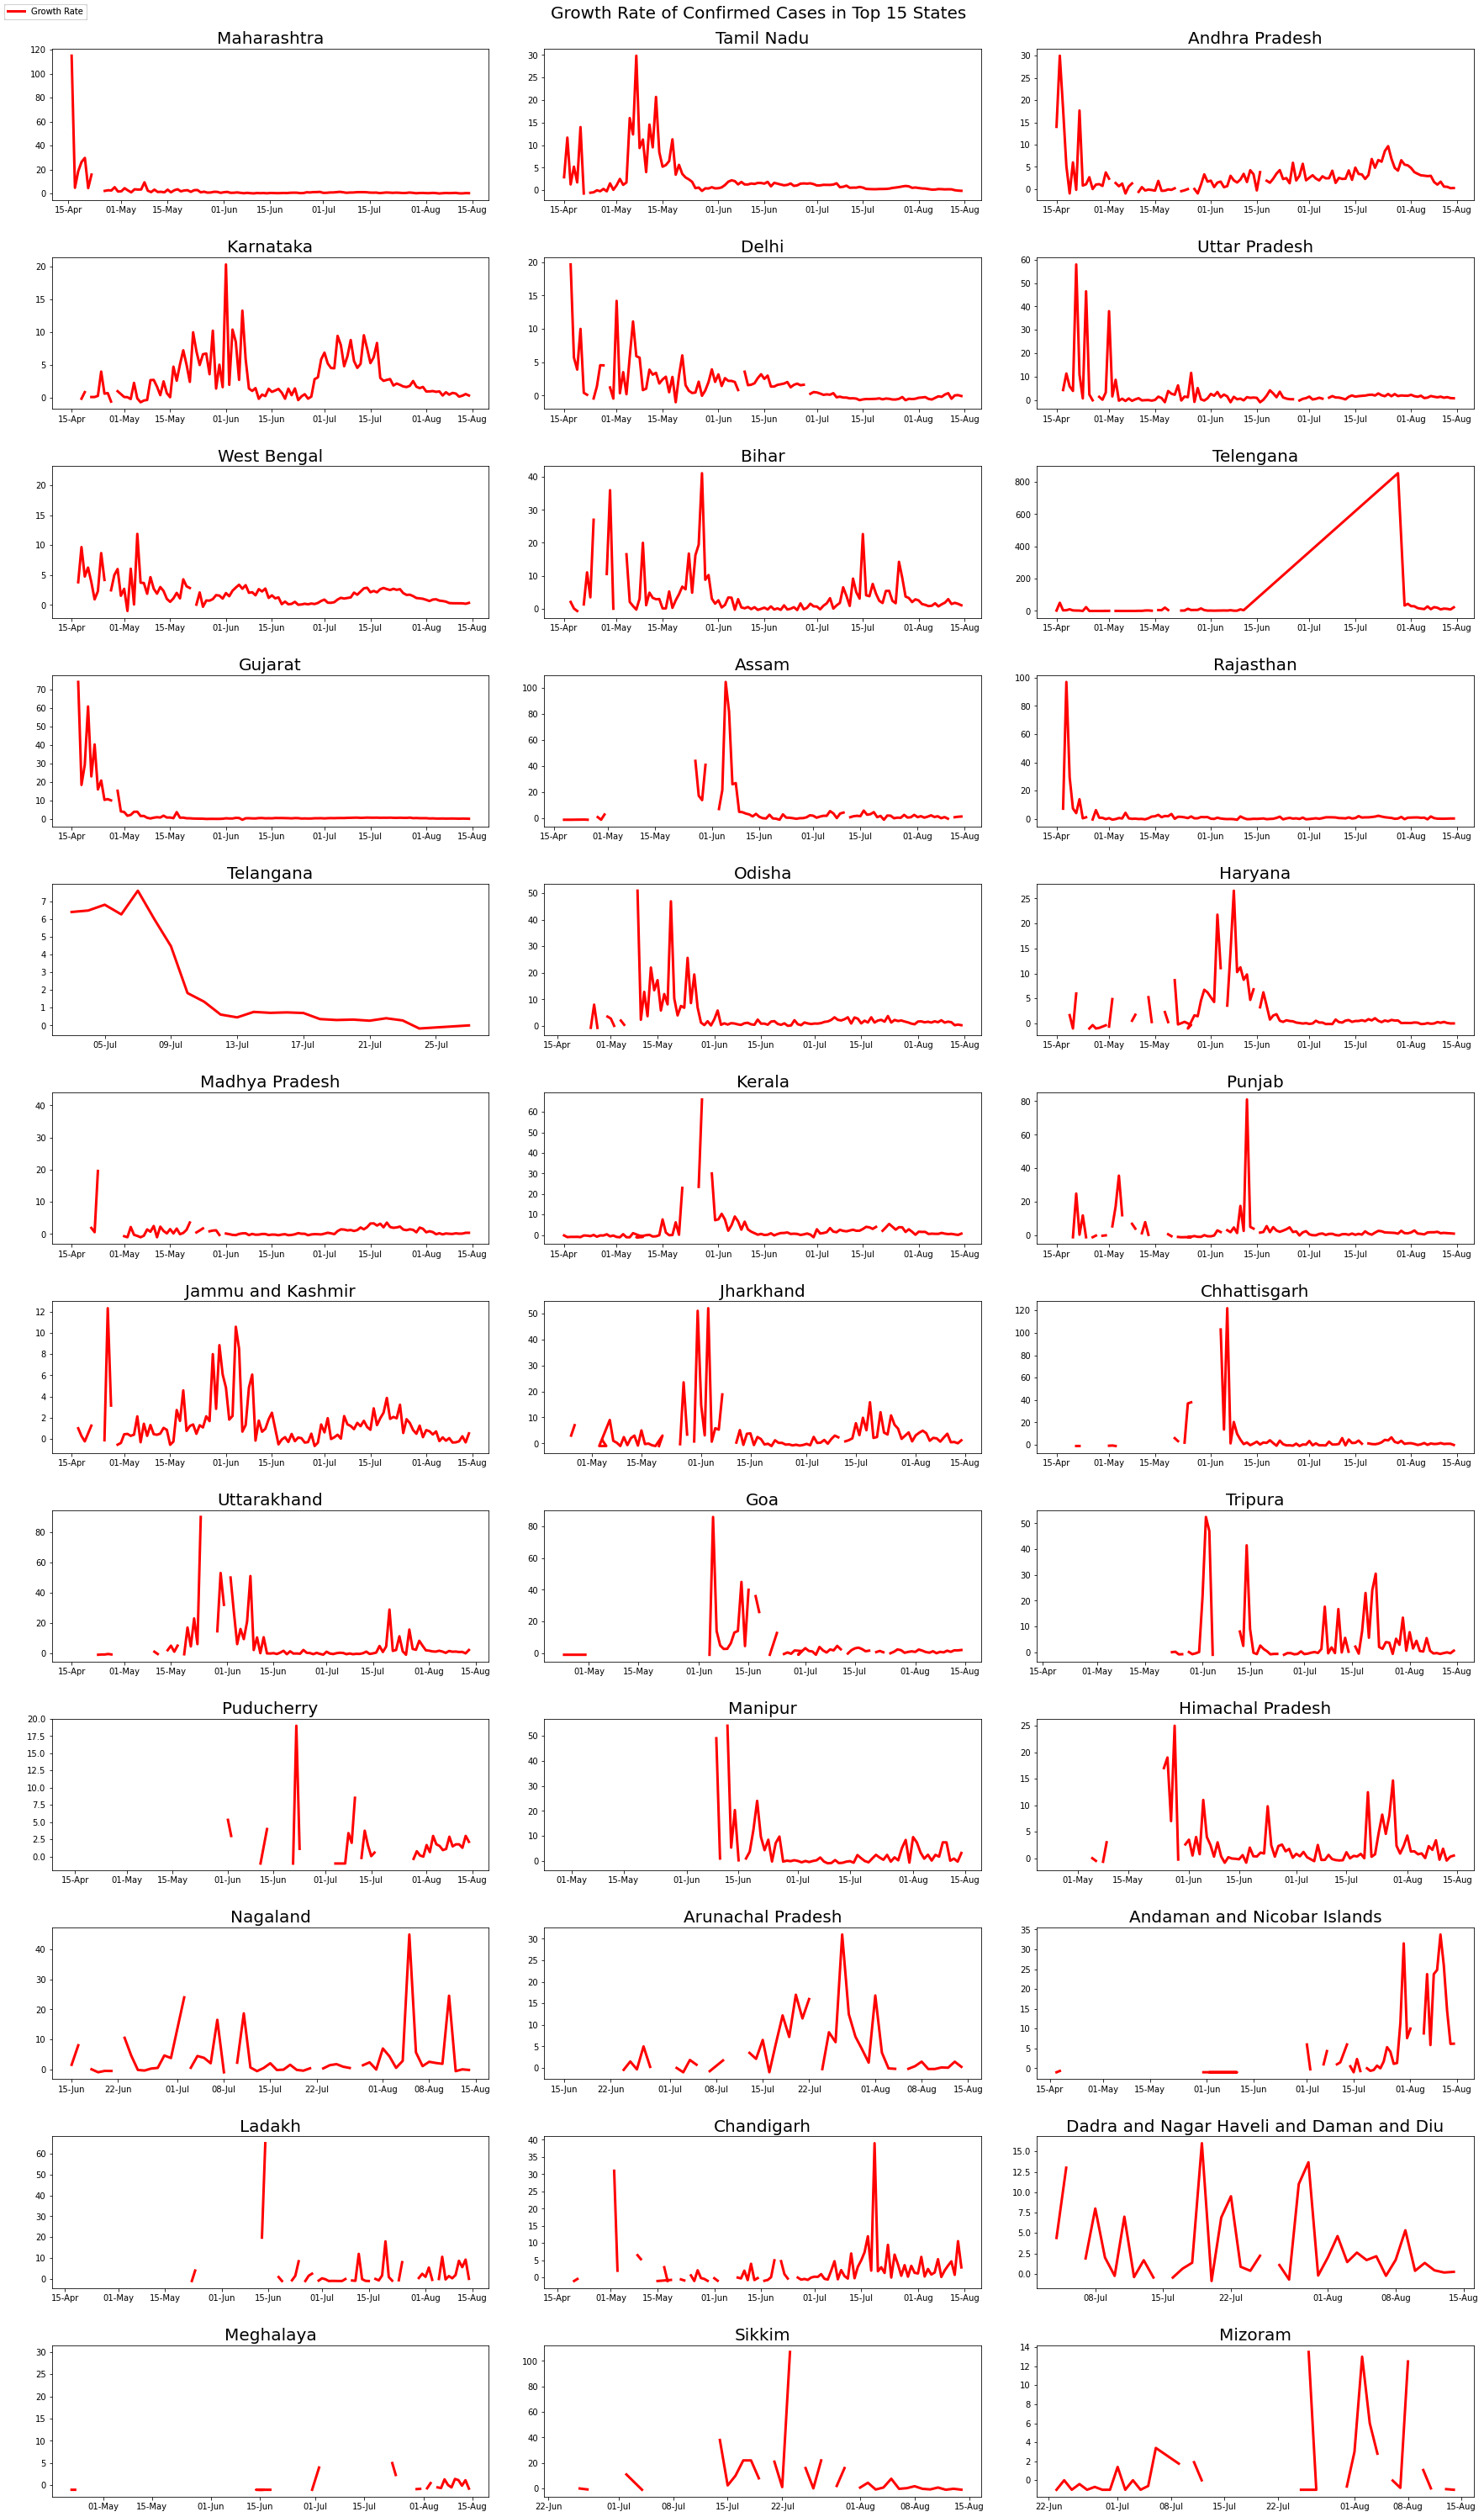

In [29]:
fig = plt.figure(figsize=(25,45))
plt.suptitle('Growth Rate of Confirmed Cases in Top 15 States',fontsize=20,y=1)
for i, state in enumerate(states):
    df1 = latest[latest['State/UnionTerritory']==state][1:].sort_values('Confirmed', ascending= True).reset_index().fillna(0)
    df2 = latest[latest['State/UnionTerritory']==state][:-1].sort_values('Confirmed', ascending= True).reset_index().fillna(0)
    states_confirmed = list(df1['Confirmed']-df2['Confirmed'])
    states_deaths = list(df1['Deaths']-df2['Deaths'])
    states_recovered = list(df1['Cured']-df2['Cured'])
    states_dates = df1['Date'].tolist()
    swdf = pd.DataFrame({'states_confirmed':states_confirmed,
                        'states_deaths':states_deaths,
                        'states_recovered':states_recovered,
                        'states_dates':states_dates})
    ax = fig.add_subplot(len(states)//3+1,3,i+1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.plot(states_dates[20:],swdf['states_confirmed'].pct_change(periods=20)[20:],color='red',label = 'Growth Rate',linewidth =3)
    plt.title(state,fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc='upper left')
plt.tight_layout(pad=3)

In [30]:
individual_details['detected_state'].unique()

array(['Kerala', 'Delhi', 'Telangana', 'Rajasthan', 'Haryana',
       'Uttar Pradesh', 'Ladakh', 'Tamil Nadu', 'Jammu and Kashmir',
       'Karnataka', 'Maharashtra', 'Punjab', 'Andhra Pradesh',
       'Uttarakhand', 'Odisha', 'Puducherry', 'West Bengal', 'Chandigarh',
       'Chhattisgarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Goa',
       'Andaman and Nicobar Islands', 'Jharkhand', 'Assam',
       'Arunachal Pradesh', 'Tripura', 'Meghalaya'], dtype=object)

In [31]:
individual_details[individual_details['detected_state']=='West Bengal']['detected_district'].value_counts().index

Index(['Kolkata', 'Nadia', 'North 24 Parganas', 'Purba Medinipur', 'Howrah',
       'Hooghly', 'South 24 Parganas', 'Kalimpong'],
      dtype='object')

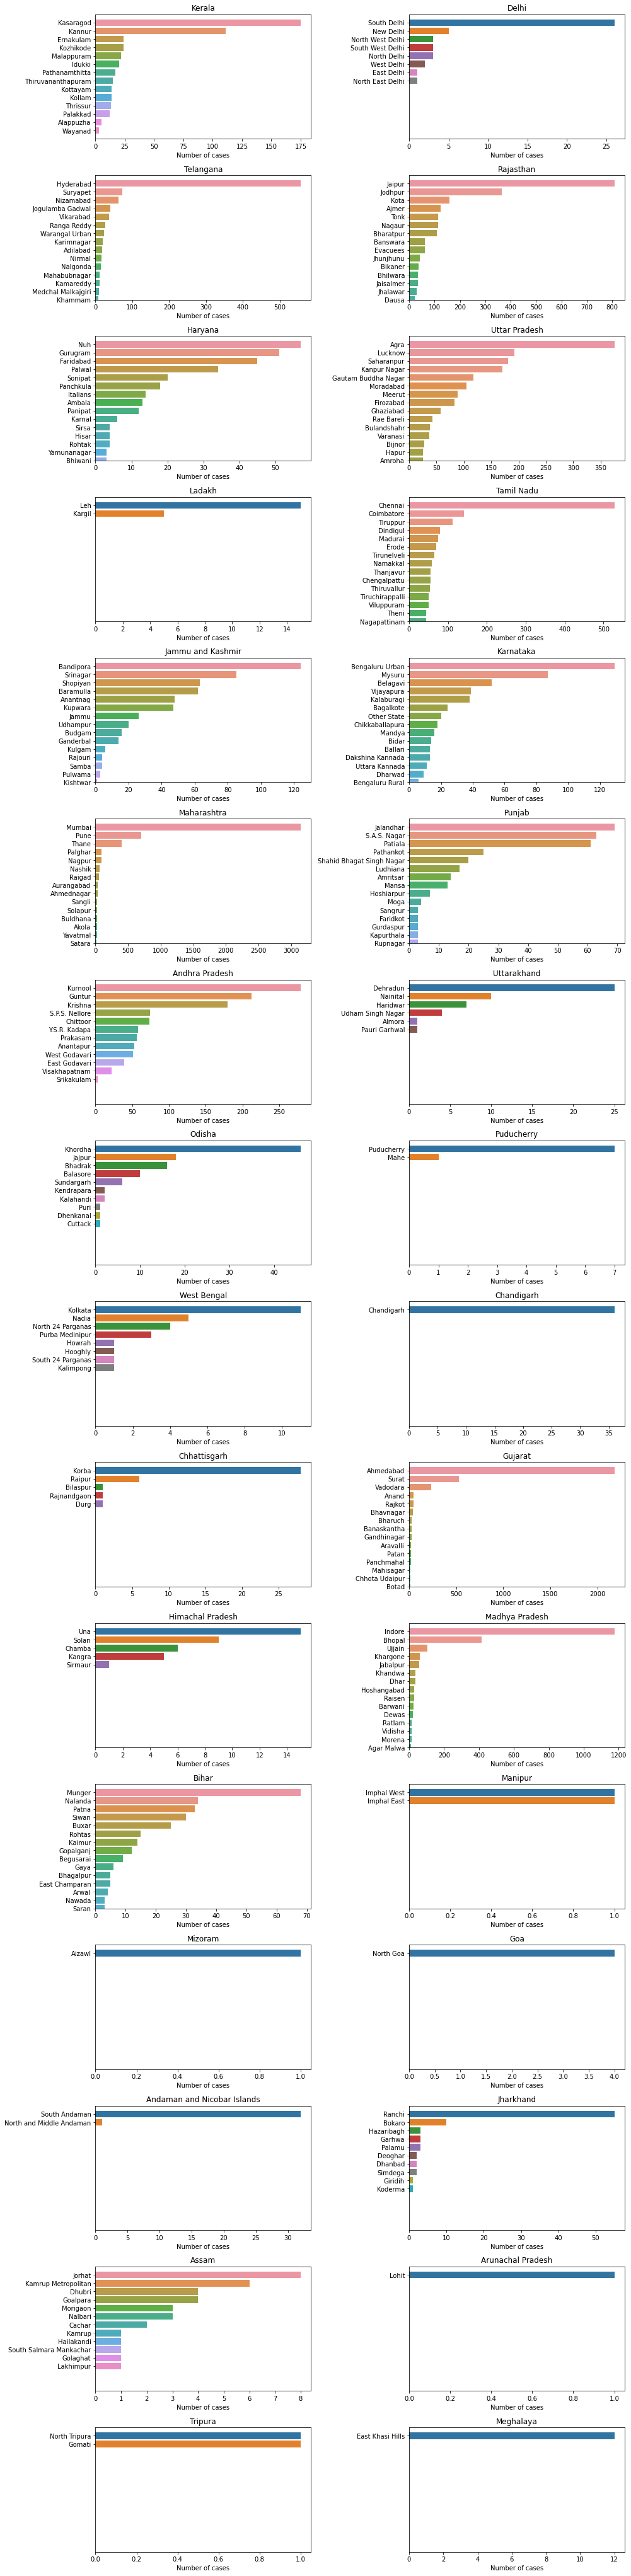

In [32]:
states = individual_details['detected_state'].unique()
plt.figure(figsize=(14,60))
for i, state in enumerate(states):
    plt.subplot(len(states)//2+1,2,i+1)
    y_order = individual_details[individual_details['detected_state']==state]['detected_district'].value_counts().index
    sns.countplot(data=individual_details[individual_details['detected_state']==state],y='detected_district',order=y_order)
    plt.xlabel('Number of cases')
    plt.ylabel('')
    plt.title(state)
    plt.ylim(14,-1)
plt.tight_layout()

In [33]:
latest.tail()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active
5191,5192,2020-08-14,8:00 AM,Telengana,-,-,64284,674,88396,23438
5192,5193,2020-08-14,8:00 AM,Tripura,-,-,5015,46,6767,1706
5193,5194,2020-08-14,8:00 AM,Uttarakhand,-,-,7014,143,11302,4145
5194,5195,2020-08-14,8:00 AM,Uttar Pradesh,-,-,88786,2280,140775,49709
5195,5196,2020-08-14,8:00 AM,West Bengal,-,-,78617,2259,107323,26447


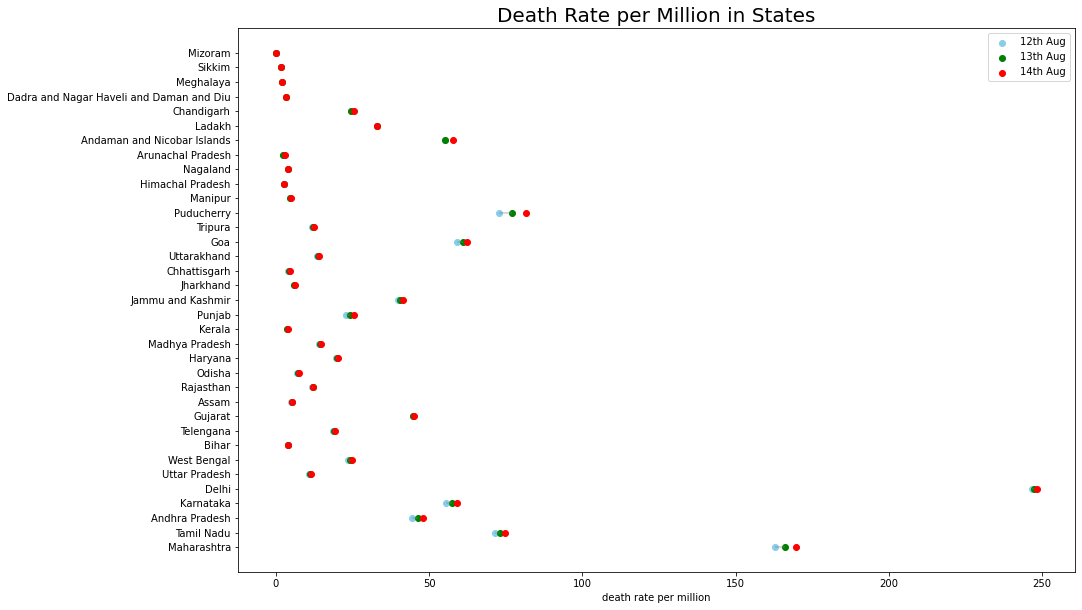

In [34]:
population['in_million'] = population['Population']/1000000
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')[['Confirmed','Deaths','Cured']].max().reset_index()
state_cases = state_cases.sort_values('Confirmed',ascending=False).fillna(0)
states = state_cases['State/UnionTerritory'].tolist()
[states.remove(st) for st in ['Telangana***','Telengana***','Telangana','Unassigned','Dadar Nagar Haveli','Daman & Diu','Cases being reassigned to states']]
s = list()
d1 = list()
d2 = list()
d3 = list()

for state in states:
    k = list(india_covid_19[india_covid_19['State/UnionTerritory']==state]['Deaths'].tail(3))
    p = float(population[population['State / Union Territory']==state]['in_million'])
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))
    s.append(state)
state_death_rate = pd.DataFrame({'state':s,'day1':d1,'day2':d2,'day3':d3})

plt.figure(figsize=(15,10))
plt.hlines(y=state_death_rate['state'],xmin=state_death_rate['day1'],xmax=state_death_rate['day2'],color='grey',alpha=0.4)
plt.scatter(state_death_rate['day1'],state_death_rate['state'],color='skyblue',label='12th Aug')
plt.scatter(state_death_rate['day2'],state_death_rate['state'],color='green',label='13th Aug')
plt.scatter(state_death_rate['day3'],state_death_rate['state'],color='red',label='14th Aug')
plt.legend()
plt.title('Death Rate per Million in States',fontsize=20)
plt.xlabel('death rate per million')
plt.show()

In [35]:
hospital_beds = hospital_beds.drop([36])

In [36]:
cols_object = hospital_beds.columns[2:8].tolist()
for cols in cols_object:
    hospital_beds[cols] = hospital_beds[cols].astype(int,errors='ignore')
hospital_beds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sno                               36 non-null     int64  
 1   State/UT                          36 non-null     object 
 2   NumPrimaryHealthCenters_HMIS      36 non-null     int32  
 3   NumCommunityHealthCenters_HMIS    36 non-null     int32  
 4   NumSubDistrictHospitals_HMIS      29 non-null     float64
 5   NumDistrictHospitals_HMIS         36 non-null     int32  
 6   TotalPublicHealthFacilities_HMIS  36 non-null     int32  
 7   NumPublicBeds_HMIS                36 non-null     int32  
 8   NumRuralHospitals_NHP18           36 non-null     int64  
 9   NumRuralBeds_NHP18                36 non-null     int64  
 10  NumUrbanHospitals_NHP18           36 non-null     int64  
 11  NumUrbanBeds_NHP18                36 non-null     int64  
dtypes: float64

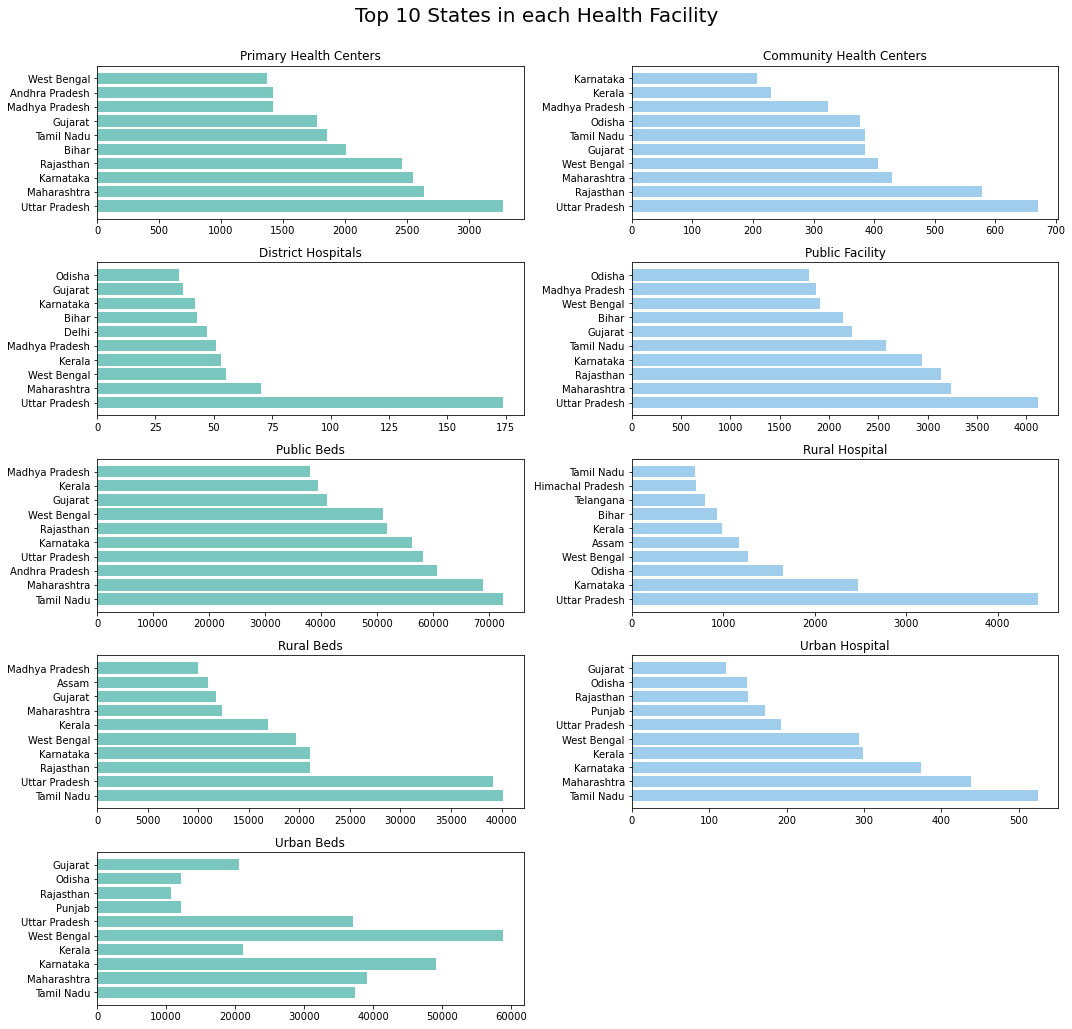

In [37]:
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')

top_rural_hos = hospital_beds.nlargest(10,'NumRuralHospitals_NHP18')
top_rural_beds = hospital_beds.nlargest(10,'NumRuralBeds_NHP18')
top_urban_hos = hospital_beds.nlargest(10,'NumUrbanHospitals_NHP18')
top_urban_beds = hospital_beds.nlargest(10,'NumUrbanBeds_NHP18')


plt.figure(figsize=(15,15))
plt.suptitle('Top 10 States in each Health Facility', fontsize=20)

plt.subplot(9//2+1,2,1)
plt.title('Primary Health Centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color='#7AC7BF')

plt.subplot(9//2+1,2,2)
plt.title('Community Health Centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color='#A1CDEC')

plt.subplot(9//2+1,2,3)
plt.title('District Hospitals')
plt.barh(top_10_district_hospitals['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color='#7AC7BF')

plt.subplot(9//2+1,2,4)
plt.title('Public Facility')
plt.barh(top_10_public_facility['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#A1CDEC')

plt.subplot(9//2+1,2,5)
plt.title('Public Beds')
plt.barh(top_10_public_beds['State/UT'],top_10_public_beds['NumPublicBeds_HMIS'],color='#7AC7BF')

plt.subplot(9//2+1,2,6)
plt.title('Rural Hospital')
plt.barh(top_rural_hos['State/UT'],top_rural_hos['NumRuralHospitals_NHP18'],color='#A1CDEC')

plt.subplot(9//2+1,2,7)
plt.title('Rural Beds')
plt.barh(top_rural_beds['State/UT'],top_rural_beds['NumRuralBeds_NHP18'],color='#7AC7BF')

plt.subplot(9//2+1,2,8)
plt.title('Urban Hospital')
plt.barh(top_urban_hos['State/UT'],top_urban_hos['NumUrbanHospitals_NHP18'],color='#A1CDEC')

plt.subplot(9//2+1,2,9)
plt.title('Urban Beds')
plt.barh(top_urban_hos['State/UT'],top_urban_hos['NumUrbanBeds_NHP18'],color='#7AC7BF')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [38]:
state_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4224 entries, 0 to 4223
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4224 non-null   datetime64[ns]
 1   State         4224 non-null   object        
 2   TotalSamples  4224 non-null   float64       
 3   Negative      2681 non-null   float64       
 4   Positive      4131 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 165.1+ KB


In [39]:
state_testing.Negative = state_testing.Negative.fillna(0).astype('float64')

In [40]:
state_testing.transpose()

,0,1,2,3,4,5,6,7,8,9,...,4214,4215,4216,4217,4218,4219,4220,4221,4222,4223
Date,2020-04-17 00:00:00,2020-04-24 00:00:00,2020-04-27 00:00:00,2020-05-01 00:00:00,2020-05-16 00:00:00,2020-05-19 00:00:00,2020-05-20 00:00:00,2020-05-21 00:00:00,2020-05-22 00:00:00,2020-05-23 00:00:00,...,2020-08-07 00:00:00,2020-08-08 00:00:00,2020-08-09 00:00:00,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00,2020-08-16 00:00:00
State,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,Andaman and Nicobar Islands,...,West Bengal,West Bengal,West Bengal,West Bengal,West Bengal,West Bengal,West Bengal,West Bengal,West Bengal,West Bengal
TotalSamples,1403,2679,2848,3754,6677,6965,7082,7167,7263,7327,...,1.05451e+06,1.07966e+06,1.1059e+06,1.1322e+06,1.15921e+06,1.18692e+06,1.21696e+06,1.24827e+06,1.28249e+06,1.31477e+06
Negative,1210,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Positive,12,27,33,33,33,33,33,33,33,33,...,89666,92615,95554,98459,NaN,NaN,107323,110358,113432,116498


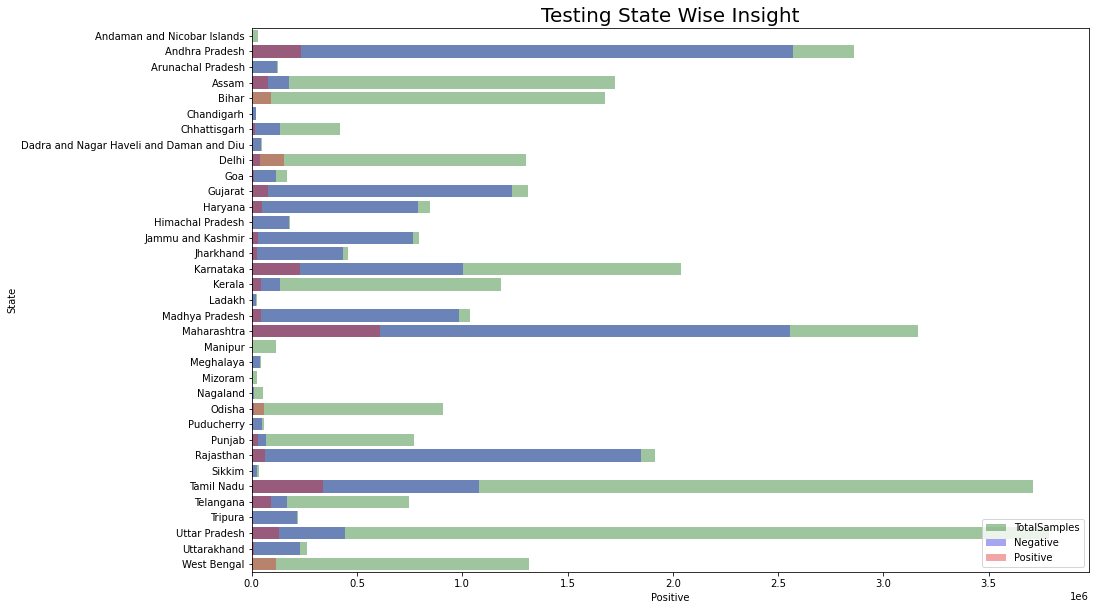

In [41]:
state_test = pd.pivot_table(state_testing,values=['TotalSamples','Negative','Positive'],index='State',aggfunc='max').reset_index()

plt.figure(figsize=(15,10))
sns.set_color_codes('pastel')
sns.barplot(x='TotalSamples',y=state_test.State,data=state_test,color='green',alpha=.4,label='TotalSamples')
sns.barplot(x='Negative',y=state_test.State,data=state_test,color='blue',alpha=.4,label='Negative')
sns.barplot(x='Positive',y=state_test.State,data=state_test,color='red',alpha=.4,label='Positive')
plt.title('Testing State Wise Insight',fontsize=20)
plt.legend(loc='lower right',frameon=True)
plt.show()

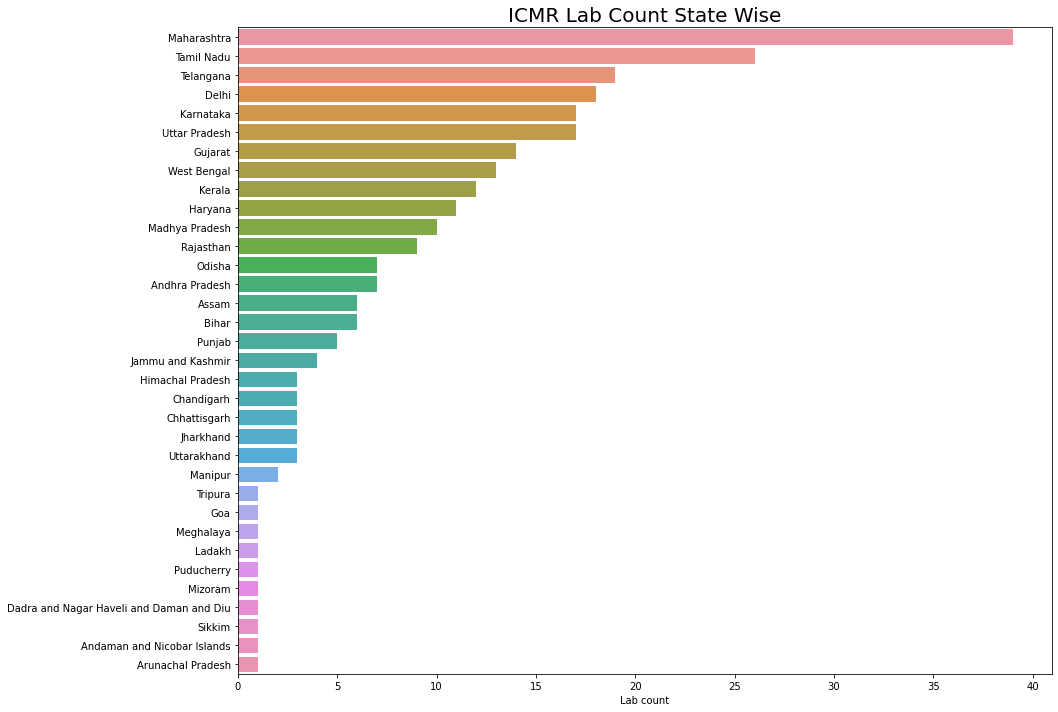

In [42]:
lab_count = ICMR_labs.state.value_counts().reset_index()

plt.figure(figsize=(15,10))
plt.title('ICMR Lab Count State Wise',fontsize=20)
sns.set_color_codes('pastel')
sns.barplot(y='index',x='state',data=lab_count)
plt.tight_layout()
plt.xlabel('Lab count')
plt.ylabel('')
plt.show()

In [43]:
confirmed_df.groupby('Country/Region').sum().reset_index()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20
0,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,...,38113,38129,38140,38143,38162,38165,38196,38243,38288,38304
1,Albania,41.153300,20.168300,0,0,0,0,0,0,0,...,8927,9083,9195,9279,9380,9513,9606,9728,9844,9967
2,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,...,42619,43016,43403,43781,44146,44494,44833,45158,45469,45773
3,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,...,1098,1098,1124,1124,1124,1176,1184,1199,1199,1215
4,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,...,2332,2415,2471,2551,2624,2654,2729,2777,2805,2876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,...,20155,20677,21251,21668,22204,22729,23281,23875,24471,25142
184,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
185,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,...,1930,1933,1943,1946,1953,1958,1962,1976,1979,1983
186,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,...,11376,11601,11779,11902,12025,12097,12381,12415,12523,12639


In [44]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
india_confirmed = df1[df1['Country/Region']=='India'].loc[:,'2/4/20':].values.tolist()[0]
india_df = pd.DataFrame({'india_confirmed':india_confirmed})
india_df['india_confirmed'].pct_change().mean()

0.08399488623112643

In [45]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.083994886231126


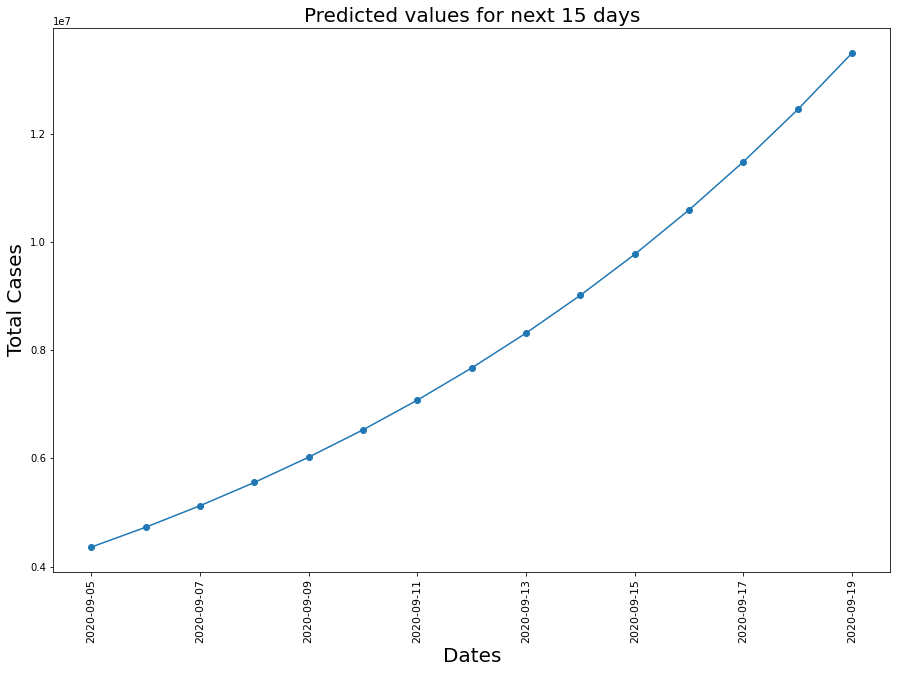

In [46]:
prediction_dates = []
start_date = dates_india[-1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][-1]

predicted_cases = []
for i in range(15):
    predicted_value = previous_day_cases * growth_factor
    # print(predicted_value)
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize=(15,10))
plt.xticks(rotation=90,fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Total Cases',fontsize=20)
plt.title('Predicted values for next 15 days',fontsize=20)
plt.plot_date(y=predicted_cases,x=prediction_dates,linestyle='-')

In [47]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


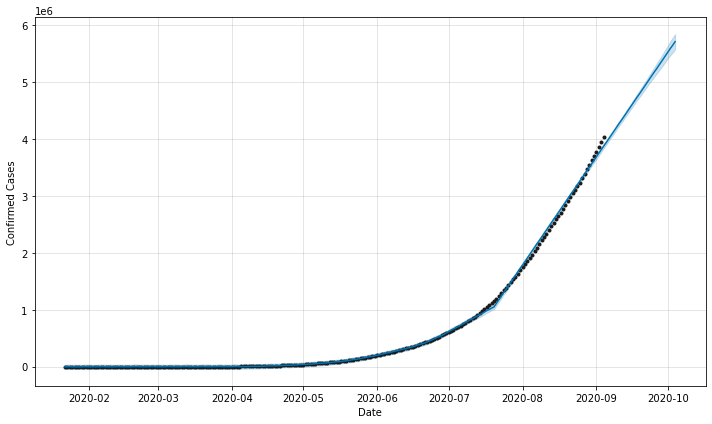

In [85]:
india_confirmed = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':].values.tolist()[0]
dates = df1.columns[3:]
data = pd.DataFrame({'ds':dates,'y':india_confirmed})

prop = Prophet()
prop.fit(data)
future = prop.make_future_dataframe(periods=30)
prop_forecast = prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = plot_plotly(prop,prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

In [104]:
data

,ds,y
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0
...,...,...
222,8/31/20,3691166
223,9/1/20,3769523
224,9/2/20,3853406
225,9/3/20,3936747


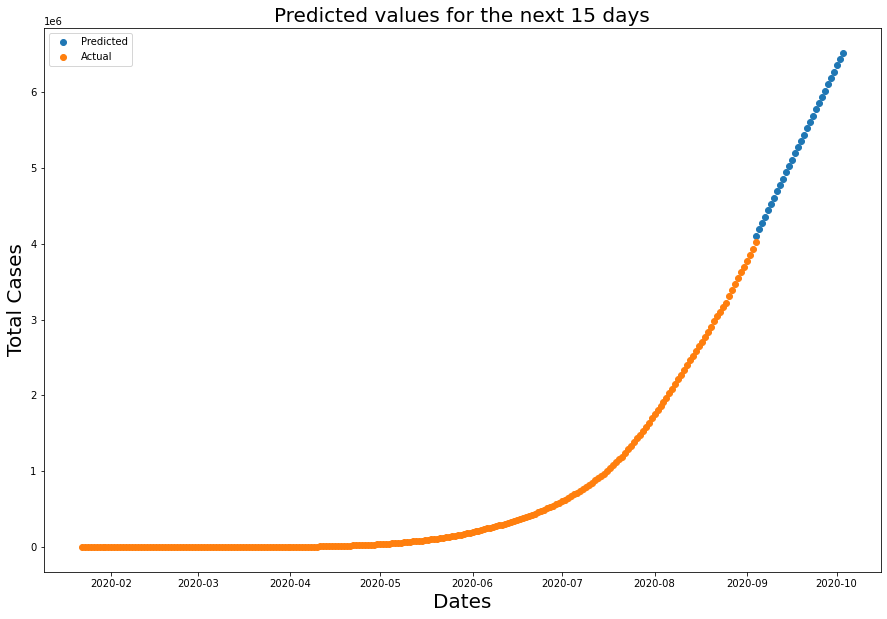

In [117]:
arima = ARIMA(data['y'],order=(5,1,0))
arima = arima.fit(trend='c',full_output=True,disp=True)
forecast = arima.forecast(30)
pred = forecast[0].tolist()

start_date = data['ds'].max()
prediction_dates = [datetime.datetime.strptime(start_date,'%m/%d/%y') + datetime.timedelta(days=i) for i in range(30)]

plt.figure(figsize=(15,10))
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Total Cases',fontsize=20)
plt.title('Predicted values for the next 15 days',fontsize=20)

plt.plot_date(y=pred,x=prediction_dates,label='Predicted')
plt.plot_date(y=data['y'],x=pd.to_datetime(data['ds']),label='Actual')
plt.legend()